In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # 使用 auto 适配 notebook
import os

# 导入我们的模型库
from models import M2_GNN_Regressor, M3_Physics_Diffusion, DiffusionScheduler

# 配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# 路径
DATA_PATH = "../data/processed/cigre_lv_graph_dataset_v1.pt"
# 确保这里的文件名与你刚才训练保存的一致 (best 或 latest)
MODEL_PATH_M2 = "../models/checkpoints/m2_best.pth"
MODEL_PATH_M3 = "../models/checkpoints/m3_best.pth"

# 绘图风格
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 140

🚀 Device: cuda


In [2]:
# Cell 2: Load Data & Models

# 1. 加载测试数据
print("📂 Loading Test Data...")
try:
    data = torch.load(DATA_PATH, weights_only=False)
except TypeError:
    data = torch.load(DATA_PATH)

test_idx = data['test_idx']
# 提取测试集 Tensor
test_p = data['Y_p'][test_idx].to(device)
test_v = data['Y_v'][test_idx].to(device)

# 静态拓扑
static_edge_index = data['edge_index'].to(device)
static_edge_attr = data['edge_attr'].to(device)
N_NODES = data['n_nodes']

print(f"✅ Test Data Loaded: {test_p.shape[0]} samples.")

# 2. 加载模型
hidden_dim = 64

model_m2 = M2_GNN_Regressor(hidden_dim=hidden_dim).to(device)
model_m2.load_state_dict(torch.load(MODEL_PATH_M2, map_location=device))
model_m2.eval()

model_m3 = M3_Physics_Diffusion(hidden_dim=hidden_dim).to(device)
model_m3.load_state_dict(torch.load(MODEL_PATH_M3, map_location=device))
model_m3.eval()

print("✅ Models Loaded & Set to Eval Mode.")

📂 Loading Test Data...
✅ Test Data Loaded: 5002 samples.
✅ Models Loaded & Set to Eval Mode.


In [3]:
# Cell 3: Reverse Diffusion Sampler

@torch.no_grad()
def sample_m3(model, condition, edge_index, edge_attr, batch_idx, n_samples=1):
    """
    M3 推理逻辑: 从纯噪声 x_T 开始，逐步去噪得到 x_0
    """
    model.eval()
    scheduler = model.scheduler
    num_timesteps = scheduler.num_timesteps
    
    # condition shape: [N_nodes, 6]
    num_nodes = condition.shape[0]
    
    # 1. 初始噪声 x_T ~ N(0, I)
    x_t = torch.randn(num_nodes, 1, device=device)
    
    # 2. 倒序遍历时间步 (Step t from T-1 to 0)
    # 使用 tqdm 显示去噪进度
    for t in tqdm(reversed(range(0, num_timesteps)), desc="Denoising", total=num_timesteps, leave=False):
        
        # 构造时间 tensor (广播到所有节点)
        # 我们的模型需要 t 是 [Batch] 维度，这里 batch_size=1 (也就是一张图)
        # 所以 t_tensor 应该是一个长为 num_nodes 的向量 (因为我们在 models.py 里是用 batch_idx 索引的)
        
        # 获取当前图的 Batch Size (如果是单图，batch_idx 全为 0，max=0，size=1)
        batch_size = batch_idx.max().item() + 1
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        
        # A. 预测噪声 epsilon_theta
        noise_pred = model(x_t, t_batch, condition, edge_index, edge_attr, batch_idx)
        
        # B. 计算去噪后的均值 (Mean)
        beta_t = scheduler.betas[t]
        alpha_t = scheduler.alphas[t]
        alpha_bar_t = scheduler.alphas_cumprod[t]
        
        # DDPM 后验均值公式
        coeff1 = 1 / torch.sqrt(alpha_t)
        coeff2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mean = coeff1 * (x_t - coeff2 * noise_pred)
        
        # C. 采样下一步 (加一点点噪声 sigma，除非是最后一步 t=0)
        if t > 0:
            z = torch.randn_like(x_t)
            sigma_t = torch.sqrt(beta_t)
            x_t = mean + sigma_t * z
        else:
            x_t = mean # 最后一步不加噪
            
    return x_t

In [4]:
# Cell 4: Create a Low-Observability Scenario

# 1. 随机选一个样本
sample_id = 42 # 固定一个 ID 以便复现
p_true = test_p[sample_id].view(-1, 1) # [44, 1]
v_true = test_v[sample_id].view(-1, 1) # [44, 1]

# 2. 制造掩码 (Masking)
OBSERVABILITY = 0.2  # 只有 20% 的节点有传感器
mask = torch.rand(N_NODES, 1, device=device) < OBSERVABILITY
mask = mask.float()

# 确保至少有一个点被观测到 (避免全黑)
if mask.sum() == 0: mask[0] = 1.0

# 3. 构造 Condition
# 模拟量测噪声
p_meas = p_true + torch.randn_like(p_true) * 0.01
v_meas = v_true + torch.randn_like(v_true) * 0.01

# Apply Mask
p_in = p_meas * mask
v_in = v_meas * mask
q_in = p_in * 0.33 # 假设

# 拼接输入 [P, Q, V, M, M, M]
condition = torch.cat([p_in, q_in, v_in, mask, mask, mask], dim=-1)

# Batch Index (单图)
batch_idx = torch.zeros(N_NODES, dtype=torch.long, device=device)

print(f"📉 Scenario Created: {mask.sum().item()} observed nodes out of {N_NODES}.")

📉 Scenario Created: 9.0 observed nodes out of 44.


In [5]:
# Cell 5: Comparisons (M2 vs M3 Ensemble)

# 1. M2 推理 (一次搞定)
print("🤖 Running M2 (Regression)...")
v_m2 = model_m2(condition, static_edge_index, static_edge_attr, batch_idx)

# 2. M3 推理 (生成 20 次，看分布)
print("✨ Running M3 (Diffusion Ensemble)...")
m3_samples = []
NUM_SAMPLES = 20

for i in range(NUM_SAMPLES):
    sample = sample_m3(model_m3, condition, static_edge_index, static_edge_attr, batch_idx)
    m3_samples.append(sample.cpu().numpy().flatten())

m3_samples = np.array(m3_samples) # [20, 44]
m3_mean = np.mean(m3_samples, axis=0) # 平均预测
m3_std = np.std(m3_samples, axis=0)   # 不确定性 (置信区间)

print("✅ Inference Complete.")

🤖 Running M2 (Regression)...
✨ Running M3 (Diffusion Ensemble)...


Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

✅ Inference Complete.


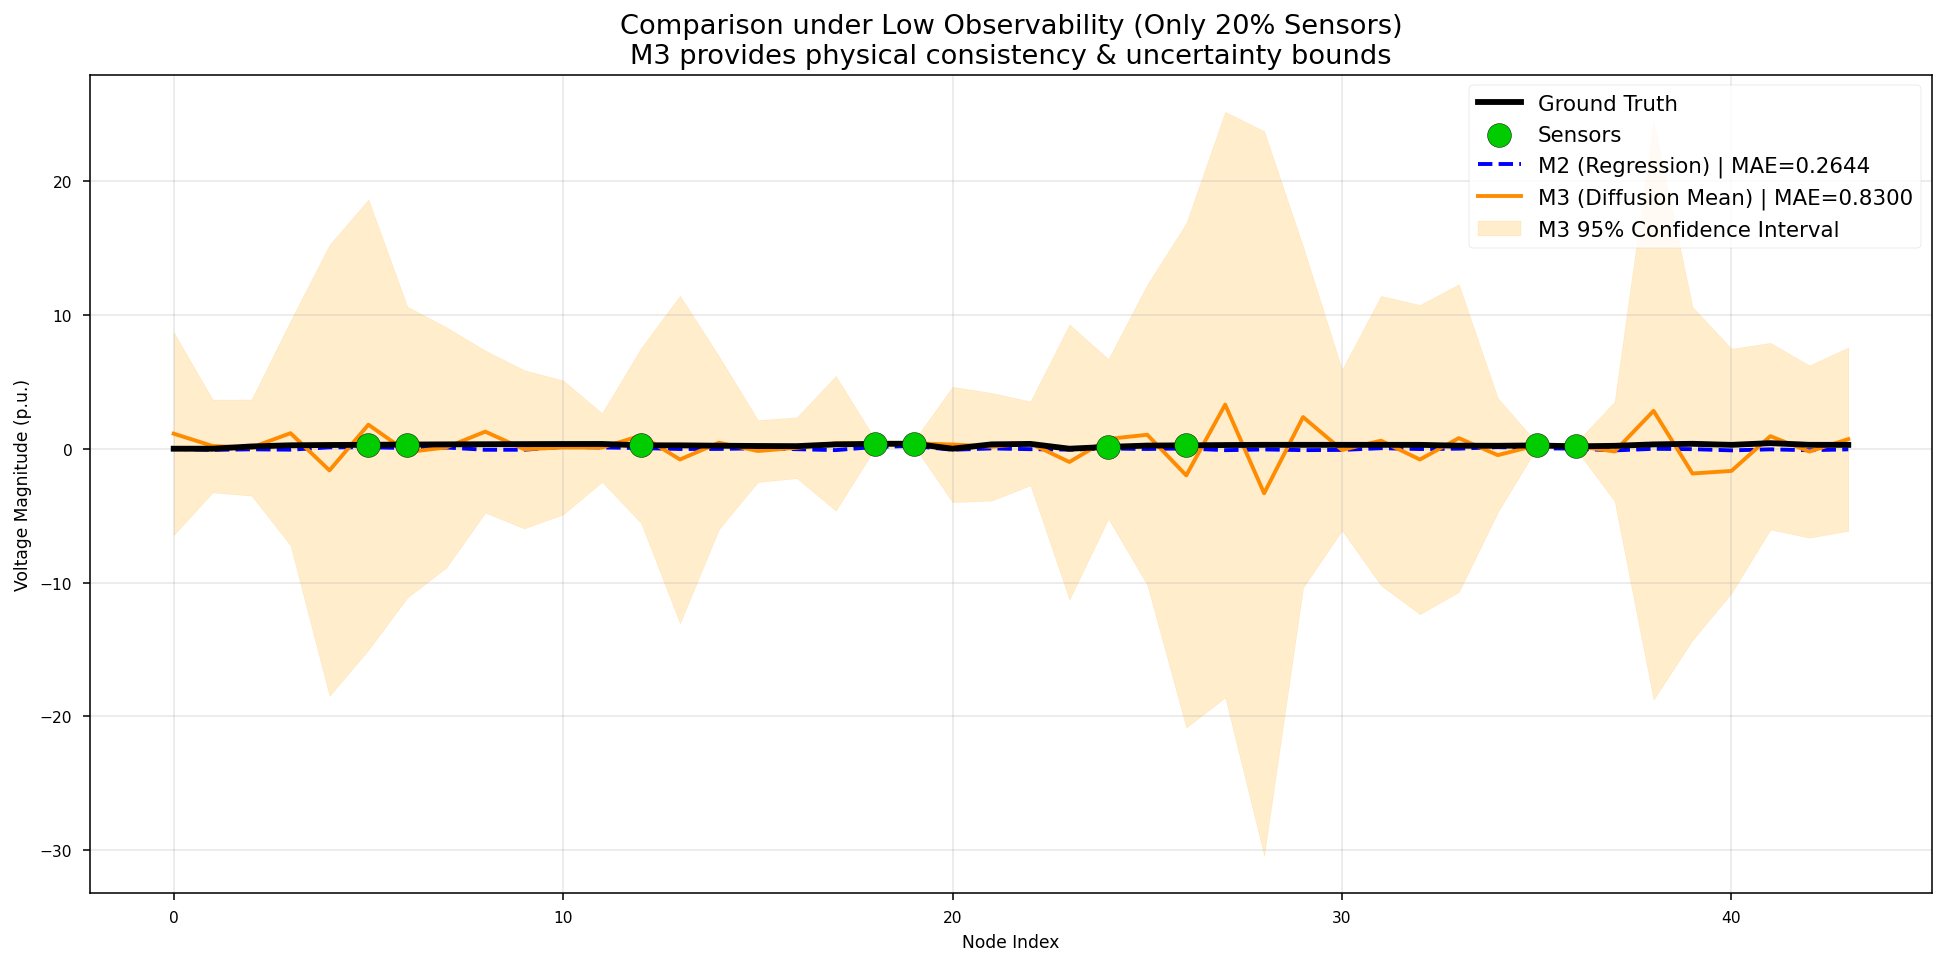

In [6]:
# Cell 6: Plotting the Results

# 准备数据
v_gt = v_true.cpu().numpy().flatten()
v_m2_np = v_m2.detach().cpu().numpy().flatten()
mask_np = mask.cpu().numpy().flatten()
x_axis = np.arange(N_NODES)

# 计算 MAE
mae_m2 = np.mean(np.abs(v_m2_np - v_gt))
mae_m3 = np.mean(np.abs(m3_mean - v_gt))

plt.figure(figsize=(14, 7))

# 1. 绘制真实值
plt.plot(x_axis, v_gt, 'k-', linewidth=3, label='Ground Truth', zorder=10)

# 2. 绘制传感器位置 (绿点)
observed_idx = np.where(mask_np == 1)[0]
plt.scatter(observed_idx, v_gt[observed_idx], color='#00CC00', s=150, edgecolors='black', label='Sensors', zorder=20)

# 3. 绘制 M2 (蓝色虚线)
plt.plot(x_axis, v_m2_np, color='blue', linestyle='--', linewidth=2, label=f'M2 (Regression) | MAE={mae_m2:.4f}')

# 4. 绘制 M3 (橙色实线 + 阴影区间)
plt.plot(x_axis, m3_mean, color='darkorange', linewidth=2, label=f'M3 (Diffusion Mean) | MAE={mae_m3:.4f}')
# 核心亮点：不确定性区间 (Mean ± 2*Std)
plt.fill_between(x_axis, m3_mean - 2*m3_std, m3_mean + 2*m3_std, color='orange', alpha=0.2, label='M3 95% Confidence Interval')

# 装饰
plt.title(f'Comparison under Low Observability (Only {OBSERVABILITY*100:.0f}% Sensors)\nM3 provides physical consistency & uncertainty bounds', fontsize=14)
plt.xlabel('Node Index')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.legend(loc='upper right', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存
plt.savefig(f"../models/checkpoints/result_comparison.png")
plt.show()